## 1. 設定

In [1]:
place = "lab"#"colab"
firsttime = True

In [2]:
if place == "lab":
    import sys
    import os
    import torch

    # 1. srcディレクトリをパスに追加 (ImportError: Could not import BrainNetwork 対策)
    current_dir = os.getcwd()
    src_path = os.path.join(current_dir, 'src')
    if src_path not in sys.path:
        sys.path.append(src_path)

    # 2. torch.xpu エラー対策
    if not hasattr(torch, "xpu"):
        class MockXPU:
            def empty_cache(self): pass
            def device_count(self): return 0
            def manual_seed(self, seed): pass
        torch.xpu = MockXPU()

    # この後に import を行う
    from models_algonauts import AlgonautsMindEye, create_algonauts_model

In [3]:
if place == "colab":
    from google.colab import drive
    import zipfile
    import os

    # Google Driveをマウント（既にマウント済みの場合はスキップ）

    # マウント
    drive.mount("/content/drive")

    # zipファイルのパス（例：Google Drive上のアップロード先）
    zip_path = "/content/drive/MyDrive/algonauts_2023_challenge_data/train_data/subj01.zip"  # 変更してください

    # 展開先ディレクトリ
    extract_path = "/content/data/algonauts_2023_challenge_data/train_data/"  # 変更してください

    # zipファイルの確認と展開
    if os.path.exists(zip_path):
        print(f"Extracting {zip_path} to {extract_path}")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete!")
    else:
        print(f"Zip file not found at: {zip_path}")

In [4]:
# =============================================================================
# 学習設定 - 必要に応じて変更してください
# =============================================================================

# 学習モード: "dummy" | "light" | "standard"
TRAIN_MODE = "standard"

# 被験者ID
SUBJECT = "subj01"
# データパス（Google Drive上）
DATA_ROOT = "/mount/nfs6/visitor/nsd/algonauts_2023_challenge_data/train_data" if (place == 'lab') else"/content/data/algonauts_2023_challenge_data/train_data/"

# チェックポイント保存先
CHECKPOINT_DIR = "/mount/nfs6/visitor/nsd/folder/mindeye_checkpoints"if (place == 'lab') else "/content/data/mindeye_checkpoints"

# 既存の学習済みモデル（転移学習用、Noneの場合はスキップ）
PRETRAINED_CKPT_FOLDER = "/mount/nfs6/visitor/nsd/folder/mindeye_v2_cache/pretrained_model/"if (place == 'lab') else None
PRETRAINED_CKPT = PRETRAINED_CKPT_FOLDER + "train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth" if (place == 'lab') else None
# =============================================================================
# モード別設定（自動設定）
# =============================================================================
if TRAIN_MODE == "dummy":
    HIDDEN_DIM = 256
    BATCH_SIZE = 2
    NUM_EPOCHS = 1
    USE_PRIOR = False
    BLURRY_RECON = False
    DUMMY_MODE = True
elif TRAIN_MODE == "light":
    HIDDEN_DIM = 512
    BATCH_SIZE = 4
    NUM_EPOCHS = 10
    USE_PRIOR = False
    BLURRY_RECON = False
    DUMMY_MODE = False
else:  # standard
    HIDDEN_DIM = 1024
    BATCH_SIZE = 64
    NUM_EPOCHS = 20
    USE_PRIOR = True
    BLURRY_RECON = False
    DUMMY_MODE = False

print(f"Mode: {TRAIN_MODE}")
print(f"Hidden Dim: {HIDDEN_DIM}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Dummy Mode: {DUMMY_MODE}")

Mode: standard
Hidden Dim: 1024
Batch Size: 64
Epochs: 20
Dummy Mode: False


In [5]:
# 既存の学習済みモデルをhuggingfaceからダウンロードする。すでにある場合はスキップする。

from huggingface_hub import hf_hub_download, snapshot_download
hf_hub_download(
    repo_id="pscotti/mindeyev2",
    repo_type="dataset",
    filename="train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth",
    local_dir=PRETRAINED_CKPT_FOLDER
)   

'/mount/nfs6/visitor/nsd/folder/mindeye_v2_cache/pretrained_model/train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth'

## 2. 環境構築

In [6]:
# GPUの確認
!nvidia-smi

Fri Jan 16 16:42:41 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:01:00.0 Off |                    0 |
| N/A   31C    P0             40W /  300W |      14MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
if place == "colab":
    # 基本パッケージ（常に必要）
    !pip install -q torch torchvision tqdm einops h5py pillow matplotlib requests numpy
    !pip install -q omegaconf accelerate

    # OpenAI CLIP（src/models.pyが必要）
    !pip install -q git+https://github.com/openai/CLIP.git

    # webdataset（src/utils.pyが必要）
    !pip install -q webdataset

    # OpenCLIP
    !pip install -q open_clip_torch

    # ⚠️ DUMMY_MODE=Trueの場合は重いライブラリをスキップ
    if DUMMY_MODE:
        print("✓ DUMMY_MODE: Skipping heavy libraries (dalle2-pytorch, kornia, pytorch_lightning)")
    else:
        # 本番モード用の重いパッケージ
        !pip install -q pytorch_lightning
        !pip install -q kornia
        !pip install -q dalle2-pytorch
        !pip install -q diffusers transformers

In [8]:
if place == "colab":
    # リポジトリのクローン（既存の場合はスキップ）
    import os
    if not os.path.exists("/content/MindEyeV2"):
        # TODO: 自分のフォークしたリポジトリURLに変更してください
        !git clone https://github.com/boxed-mikann/MindEyeV2.git /content/MindEyeV2
    else:
        print("Repository already exists")

    # パスを追加
    import sys
    sys.path.insert(0, "/content/MindEyeV2/mysrc")
    sys.path.insert(0, "/content/MindEyeV2/src")

    os.chdir("/content/MindEyeV2")
    print(f"Working directory: {os.getcwd()}")

In [9]:
if place == "lab":
    # パスを追加
    import sys ,os

    sys.path.insert(0, "/home/pcnl_guest3/workspace/MindEyeV2/mysrc")
    sys.path.insert(0, "/home/pcnl_guest3/workspace/MindEyeV2/src")

    os.chdir("//home/pcnl_guest3/workspace/MindEyeV2")
    print(f"Working directory: {os.getcwd()}")

Working directory: /home/pcnl_guest3/workspace/MindEyeV2


In [10]:
print('Pulling latest changes from MindEyeV2 repository...')
!git pull
print('Repository update complete.')

Pulling latest changes from MindEyeV2 repository...
Already up to date.
Repository update complete.


In [11]:


# データの存在確認
import os
subj_dir = os.path.join(DATA_ROOT, SUBJECT)
if os.path.exists(subj_dir):
    print(f"✓ Data found: {subj_dir}")
    !ls -la {subj_dir}
else:
    print(f"✗ Data NOT found: {subj_dir}")
    print("Please upload Algonauts2023 data to Google Drive")

✓ Data found: /mount/nfs6/visitor/nsd/algonauts_2023_challenge_data/train_data/subj01


合計 20
drwxrwxr-x  5 pcnl_guest3 visitor 4096  1月 11  2023 .
drwxrwxr-x 10 shinji      visitor 4096 12月 16 17:31 ..
drwxr-x---  2 pcnl_guest3 visitor 4096 12月 10  2022 roi_masks
drwxr-x---  3 pcnl_guest3 visitor 4096 12月 10  2022 test_split
drwxr-x---  4 pcnl_guest3 visitor 4096 10月 31  2022 training_split


## 3. データ読み込み

In [12]:
import torch
import numpy as np
from tqdm.auto import tqdm

# 環境変数でダミーモードを設定
os.environ["MINDEYE_DUMMY"] = "1" if DUMMY_MODE else "0"

# mysrcモジュールをインポート
from algonauts_dataset import AlgonautsDataset, get_dataloader, get_total_vertices
from config import print_config, DEVICE

print_config()
print(f"\nDevice: {DEVICE}")
print(f"Total vertices for {SUBJECT}: {get_total_vertices(SUBJECT)}")

MindEyeV2 Algonauts Configuration
Environment:     Local
Device:          cuda
Dummy Mode:      False
Data Root:       D:/data/algonauts_2023_challenge_data
Checkpoint Dir:  /home/pcnl_guest3/workspace/MindEyeV2/train_logs
Output Dir:      /home/pcnl_guest3/workspace/MindEyeV2/outputs
SRC Dir:         /home/pcnl_guest3/workspace/MindEyeV2/src

Device: cuda
Total vertices for subj01: 39548


In [13]:
# =============================================================================
# 🔍 メモリデバッグ - モデル作成前
# =============================================================================
import psutil
import gc

def get_memory_info():
    """CPU/GPUメモリ情報を表示"""
    # CPUメモリ
    process = psutil.Process()
    cpu_mem_mb = process.memory_info().rss / 1024**2

    # GPUメモリ
    if torch.cuda.is_available():
        gpu_mem_mb = torch.cuda.memory_allocated() / 1024**2
        gpu_reserved_mb = torch.cuda.memory_reserved() / 1024**2
        return {
            "cpu_mb": cpu_mem_mb,
            "gpu_allocated_mb": gpu_mem_mb,
            "gpu_reserved_mb": gpu_reserved_mb,
        }
    return {"cpu_mb": cpu_mem_mb}

print("="*60)
print("📊 Memory Usage BEFORE Model Creation")
print("="*60)
mem_before = get_memory_info()
for k, v in mem_before.items():
    print(f"  {k}: {v:.2f} MB")
print("="*60)

📊 Memory Usage BEFORE Model Creation
  cpu_mb: 569.89 MB
  gpu_allocated_mb: 0.00 MB
  gpu_reserved_mb: 0.00 MB


In [14]:
# データローダー作成
import numpy
train_loader = get_dataloader(
    data_root=DATA_ROOT,
    subject=SUBJECT,
    split="train",
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

print(f"\nDataset size: {len(train_loader.dataset)}")
print(f"Number of batches: {len(train_loader)}")

# サンプルバッチを取得
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  fMRI shape: {sample_batch['fmri'].shape}")
print(f"  Image shape: {sample_batch['image'].shape}")

Loading fMRI data for subj01...
  LH shape: (9841, 19004), RH shape: (9841, 20544)
  Combined shape: (9841, 39548)
Found 9841 train images

Dataset size: 9841
Number of batches: 153

Sample batch:
  fMRI shape: torch.Size([64, 39548])
  Image shape: torch.Size([64, 3, 224, 224])


## 4. モデル作成

In [15]:
from models_algonauts import AlgonautsMindEye, create_algonauts_model
from transfer_utils import (
    load_pretrained_without_ridge,
    freeze_layers,
    get_trainable_params,
    print_parameter_summary,
)

# モデル作成
model = create_algonauts_model(
    subjects=[SUBJECT],
    hidden_dim=HIDDEN_DIM,
    seq_len=1,
    n_blocks=4,
    use_prior=USE_PRIOR,
    blurry_recon=BLURRY_RECON,
    device=DEVICE,
)

print("Model created!")
print_parameter_summary(model)

/home/pcnl_guest3/miniforge3/envs/fmri3/lib/python3.11/site-packages/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging
/home/pcnl_guest3/miniforge3/envs/fmri3/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/pcnl_guest3/miniforge3/envs/fmri3/lib/python3.11/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Model created!
Parameter Summary
Total:      731,770,520
Trainable:  731,770,504
Frozen:              16
------------------------------------------------------------
By Layer:
  🟢 ridge                40,498,176 (40,498,176 trainable)
  🟢 backbone             453,360,280 (453,360,280 trainable)
  🟢 diffusion_prior      237,912,064 (237,912,048 trainable)


In [16]:
# Notebookで実行 - 現在のモデルの形状を確認
print("Current model shapes:")
print(f"learned_query: {model.diffusion_prior.net.learned_query.shape}")
print(f"null_image_embed: {model.diffusion_prior.net.null_image_embed.shape}")

Current model shapes:
learned_query: torch.Size([256, 1664])
null_image_embed: torch.Size([256, 1664])


In [17]:
# Notebookで実行
import torch

ckpt_path = "/mount/nfs6/visitor/nsd/folder/mindeye_v2_cache/pretrained_model/train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth"
checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

# state_dictを取得
if "state_dict" in checkpoint:
    state_dict = checkpoint["state_dict"]
elif "model_state_dict" in checkpoint:
    state_dict = checkpoint["model_state_dict"]
else:
    state_dict = checkpoint

# diffusion_prior関連のキーと形状を表示
print("Diffusion Prior keys and shapes:")
for k, v in state_dict.items():
    if "diffusion_prior" in k:
        print(f"  {k}: {v.shape}")

/home/pcnl_guest3/miniforge3/envs/fmri3/compiler_compat/ld: cannot find -laio: そのようなファイルやディレクトリはありません
collect2: error: ld returned 1 exit status
/home/pcnl_guest3/miniforge3/envs/fmri3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlvsym'
/home/pcnl_guest3/miniforge3/envs/fmri3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlopen'
/home/pcnl_guest3/miniforge3/envs/fmri3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlclose'
/home/pcnl_guest3/miniforge3/envs/fmri3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlerror'
/home/pcnl_guest3/miniforge3/envs/fmri3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `dlsym'
collect2: error: ld returned 1 exit status


Diffusion Prior keys and shapes:
  diffusion_prior.noise_scheduler.betas: torch.Size([100])
  diffusion_prior.noise_scheduler.alphas_cumprod: torch.Size([100])
  diffusion_prior.noise_scheduler.alphas_cumprod_prev: torch.Size([100])
  diffusion_prior.noise_scheduler.sqrt_alphas_cumprod: torch.Size([100])
  diffusion_prior.noise_scheduler.sqrt_one_minus_alphas_cumprod: torch.Size([100])
  diffusion_prior.noise_scheduler.log_one_minus_alphas_cumprod: torch.Size([100])
  diffusion_prior.noise_scheduler.sqrt_recip_alphas_cumprod: torch.Size([100])
  diffusion_prior.noise_scheduler.sqrt_recipm1_alphas_cumprod: torch.Size([100])
  diffusion_prior.noise_scheduler.posterior_variance: torch.Size([100])
  diffusion_prior.noise_scheduler.posterior_log_variance_clipped: torch.Size([100])
  diffusion_prior.noise_scheduler.posterior_mean_coef1: torch.Size([100])
  diffusion_prior.noise_scheduler.posterior_mean_coef2: torch.Size([100])
  diffusion_prior.noise_scheduler.p2_loss_weight: torch.Size([100

In [18]:
# 転移学習（既存ckptがある場合）
if PRETRAINED_CKPT and os.path.exists(PRETRAINED_CKPT):
    print(f"Loading pretrained weights from: {PRETRAINED_CKPT}")
    loaded, missing = load_pretrained_without_ridge(
        model,
        PRETRAINED_CKPT,
        freeze_backbone=False,
        freeze_prior=True,
    )
    print(f"\nAfter transfer learning:")
    print_parameter_summary(model)
else:
    print("No pretrained checkpoint specified. Training from scratch.")
    # スクラッチ学習の場合はbackboneもfreezeしない
    pass

Loading pretrained weights from: /mount/nfs6/visitor/nsd/folder/mindeye_v2_cache/pretrained_model/train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth
Loading checkpoint from: /mount/nfs6/visitor/nsd/folder/mindeye_v2_cache/pretrained_model/train_logs/multisubject_subj01_1024hid_nolow_300ep/last.pth
Loaded 147 keys (excluding ridge)
Successfully loaded: 147 keys
Missing (non-ridge): ['diffusion_prior.net.to_time_embeds.0.weight', 'diffusion_prior.net.causal_transformer.layers.0.1.3.g', 'diffusion_prior.net.causal_transformer.layers.1.1.3.g', 'diffusion_prior.net.causal_transformer.layers.2.1.3.g', 'diffusion_prior.net.causal_transformer.layers.3.1.3.g', 'diffusion_prior.net.causal_transformer.layers.4.1.3.g', 'diffusion_prior.net.causal_transformer.layers.5.1.3.g']
Unexpected keys: ['diffusion_prior.net.to_time_embeds.0.1.net.0.0.weight', 'diffusion_prior.net.to_time_embeds.0.1.net.0.0.bias', 'diffusion_prior.net.to_time_embeds.0.1.net.1.0.weight', 'diffusion_prior.net.to_time_e

In [19]:
# =============================================================================
# 🔍 メモリデバッグ - モデル作成後
# =============================================================================
print("="*60)
print("📊 Memory Usage AFTER Model Creation")
print("="*60)
mem_after = get_memory_info()
for k, v in mem_after.items():
    print(f"  {k}: {v:.2f} MB")

print("\n📈 Memory Increase:")
for k in mem_after.keys():
    increase = mem_after[k] - mem_before.get(k, 0)
    print(f"  {k}: +{increase:.2f} MB")

# モデルパラメータ数
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# 理論的なメモリ使用量（FP32想定）
theoretical_mb = total_params * 4 / 1024**2
print(f"\n🧮 Theoretical Model Size:")
print(f"  Total params: {total_params:,}")
print(f"  Trainable params: {trainable_params:,}")
print(f"  FP32 size: {theoretical_mb:.2f} MB")
print(f"  FP16 size: {theoretical_mb/2:.2f} MB")

# モデルが実際にGPU上にあるか確認
if torch.cuda.is_available():
    sample_param = next(model.parameters())
    print(f"\n🎯 Model Device: {sample_param.device}")
    print(f"   Data Type: {sample_param.dtype}")
print("="*60)

📊 Memory Usage AFTER Model Creation
  cpu_mb: 7129.18 MB
  gpu_allocated_mb: 2792.88 MB
  gpu_reserved_mb: 2840.00 MB

📈 Memory Increase:
  cpu_mb: +6559.29 MB
  gpu_allocated_mb: +2792.88 MB
  gpu_reserved_mb: +2840.00 MB

🧮 Theoretical Model Size:
  Total params: 731,770,520
  Trainable params: 493,858,456
  FP32 size: 2791.48 MB
  FP16 size: 1395.74 MB

🎯 Model Device: cuda:0
   Data Type: torch.float32


## 5. CLIP特徴の準備

In [20]:
# セル「5. CLIP特徴の準備」

import sys
import open_clip

if DUMMY_MODE:
    from dummy_models import DummyCLIPImageEmbedder
    clip_embedder = DummyCLIPImageEmbedder().to(DEVICE)
    print("Using DummyCLIPImageEmbedder")
    clip_img_embedder = None
    clip_model = None
    
else:
    # 元のMindEyeV2と同じ方法でCLIP特徴を抽出
    clip_img_embedder = None
    clip_model = None
    
    # まず generative_models の FrozenOpenCLIPImageEmbedder を試す
    try:
        sys.path.insert(0, '/home/pcnl_guest3/workspace/MindEyeV2/src/generative_models/')
        from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
        
        clip_img_embedder = FrozenOpenCLIPImageEmbedder(
            arch="ViT-bigG-14",
            version="laion2b_s39b_b160k",
            output_tokens=True,
            only_tokens=True,
        )
        clip_img_embedder = clip_img_embedder.to(DEVICE)
        clip_img_embedder.eval()
        
        print("✅ Loaded FrozenOpenCLIPImageEmbedder (256 tokens x 1664 dim)")
        
    except Exception as e:
        print(f"⚠️ FrozenOpenCLIPImageEmbedder failed: {e}")
        print("Falling back to open_clip with manual token extraction...")
        
        clip_model, _, preprocess = open_clip.create_model_and_transforms(
            "ViT-bigG-14",
            pretrained="laion2b_s39b_b160k",
        )
        clip_model = clip_model.to(DEVICE).eval()
        for param in clip_model.parameters():
            param.requires_grad = False
        
        print("✅ Loaded open_clip ViT-bigG-14")


def get_clip_features(images):
    """画像からCLIP特徴を抽出（256 tokens x 1664 dim）"""
    with torch.no_grad():
        if DUMMY_MODE:
            return clip_embedder(images)
        
        elif clip_img_embedder is not None:
            # FrozenOpenCLIPImageEmbedderを使用
            features = clip_img_embedder(images)
            return features  # (batch, 256, 1664)
        
        elif clip_model is not None:
            # open_clipのVisual Transformerから隠れ状態を取得
            visual = clip_model.visual
            x = images
            x = visual.conv1(x)
            x = x.reshape(x.shape[0], x.shape[1], -1)
            x = x.permute(0, 2, 1)
            x = torch.cat([
                visual.class_embedding.to(x.dtype) + 
                torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device),
                x
            ], dim=1)
            x = x + visual.positional_embedding.to(x.dtype)
            x = visual.ln_pre(x)
            x = x.permute(1, 0, 2)
            x = visual.transformer(x)
            x = x.permute(1, 0, 2)
            # CLSトークンを除いて256トークン
            x = x[:, 1:257, :]  # (batch, 256, 1664)
            return x
        
        else:
            raise RuntimeError("No CLIP model available!")


# テスト
test_images = sample_batch['image'].to(DEVICE)
test_features = get_clip_features(test_images)
print(f"CLIP features shape: {test_features.shape}")
# 期待される出力: torch.Size([batch, 256, 1664])

✅ Loaded FrozenOpenCLIPImageEmbedder (256 tokens x 1664 dim)


/home/pcnl_guest3/workspace/MindEyeV2/src/generative_models/sgm/util.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(


CLIP features shape: torch.Size([64, 256, 1664])


## 6. 学習ループ

In [21]:
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

# オプティマイザ（学習可能なパラメータのみ）
trainable_params = get_trainable_params(model, mode="all_unfrozen")
print(f"Trainable parameters: {sum(p.numel() for p in trainable_params):,}")

optimizer = AdamW(trainable_params, lr=1e-4, weight_decay=1e-2)

# スケジューラ
total_steps = len(train_loader) * NUM_EPOCHS + 100  # 予備ステップを追加
scheduler = OneCycleLR(
    optimizer,
    max_lr=3e-4,
    total_steps=total_steps,
    pct_start=0.1,
)

Trainable parameters: 493,858,456


In [22]:
import torch.nn as nn
def soft_clip_loss(preds, targets, temp=0.006):
    """Soft CLIP contrastive loss"""
    # 両方とも (batch, 256, 1664) → flatten → (batch, 256*1664)
    preds = preds.float()
    targets = targets.float()
    
    preds = preds.reshape(preds.shape[0], -1)
    targets = targets.reshape(targets.shape[0], -1)
    
    # 正規化
    preds = F.normalize(preds, dim=-1)
    targets = F.normalize(targets, dim=-1)
    
    # Contrastive loss
    clip_clip = (targets @ targets.T) / temp
    brain_clip = (preds @ targets.T) / temp
    
    loss1 = -(brain_clip.log_softmax(-1) * clip_clip.softmax(-1)).sum(-1).mean()
    loss2 = -(brain_clip.T.log_softmax(-1) * clip_clip.softmax(-1)).sum(-1).mean()
    
    return (loss1 + loss2) / 2

def train_step(batch):
    """1バッチの学習ステップ"""
    model.train()

    # データ取得
    fmri = batch['fmri'].to(DEVICE)
    images = batch['image'].to(DEVICE)

    # CLIP特徴を取得（ターゲット）
    with torch.no_grad():
        clip_target = get_clip_features(images)  # (batch, emb_dim)

    # Forward
    backbone, clip_voxels, blurry = model(fmri)

    # 形状をデバッグ出力（最初のバッチのみ）
    if not hasattr(train_step, 'debug_printed'):
        print(f"Debug shapes:")
        print(f"  fmri: {fmri.shape}")
        print(f"  backbone: {backbone.shape}")
        print(f"  clip_voxels: {clip_voxels.shape}")
        print(f"  clip_target: {clip_target.shape}")
        train_step.debug_printed = True

    # clip_voxelsをflattenして使う
    # clip_voxels: (batch, seq_len, clip_emb_dim) -> (batch, seq_len * clip_emb_dim)
    clip_voxels_flat = clip_voxels.reshape(clip_voxels.shape[0], -1)
    clip_target_flat = clip_target.reshape(clip_target.shape[0], -1)

    # Loss計算
    loss = soft_clip_loss(clip_voxels_flat, clip_target_flat)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
    optimizer.step()
    scheduler.step()

    return loss.item()

In [23]:
# メモリ確認
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB allocated")
    print(f"GPU Memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB reserved")

GPU Memory: 9.95 GB allocated
GPU Memory: 11.40 GB reserved


In [ ]:
# 学習ループ
print(f"\n{'='*60}")
print(f"Starting training: {NUM_EPOCHS} epochs, {len(train_loader)} batches/epoch")
print(f"{'='*60}\n")

losses = []

for epoch in range(NUM_EPOCHS):
    epoch_losses = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for batch in pbar:
        loss = train_step(batch)
        epoch_losses.append(loss)
        pbar.set_postfix({"loss": f"{loss:.4f}"})

    avg_loss = np.mean(epoch_losses)
    losses.extend(epoch_losses)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Average Loss: {avg_loss:.4f}")

    # メモリ確認
    if torch.cuda.is_available():
        print(f"  GPU Memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

print(f"\n{'='*60}")
print("Training complete!")
print(f"{'='*60}")


Starting training: 20 epochs, 153 batches/epoch



Epoch 1/20:   0%|          | 0/153 [00:00<?, ?it/s]

Debug shapes:
  fmri: torch.Size([64, 39548])
  backbone: torch.Size([64, 256, 1664])
  clip_voxels: torch.Size([64, 256, 1664])
  clip_target: torch.Size([64, 256, 1664])


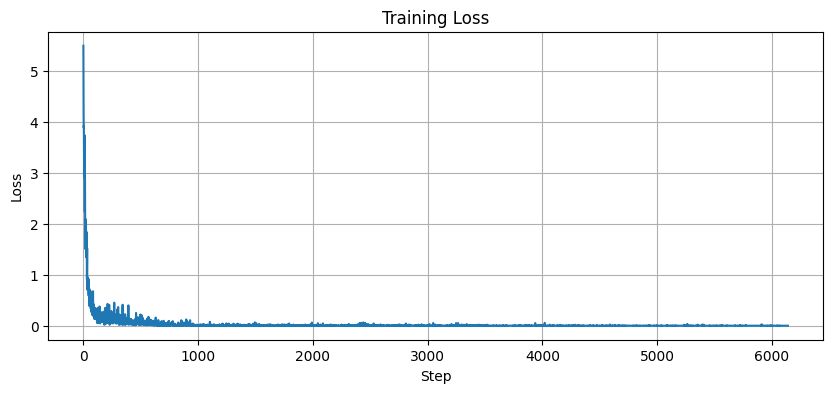

In [ ]:
# 損失の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

## 7. チェックポイント保存

In [ ]:
from transfer_utils import save_checkpoint

# 保存先ディレクトリ作成
save_dir = os.path.join(CHECKPOINT_DIR, f"algonauts_{SUBJECT}_{TRAIN_MODE}")
os.makedirs(save_dir, exist_ok=True)

# チェックポイント保存
save_checkpoint(
    model=model,
    optimizer=optimizer,
    epoch=NUM_EPOCHS,
    save_path=os.path.join(save_dir, "last.pth"),
    extra_info={
        "train_mode": TRAIN_MODE,
        "subject": SUBJECT,
        "hidden_dim": HIDDEN_DIM,
        "final_loss": losses[-1] if losses else None,
    },
)

print(f"\nCheckpoint saved to: {save_dir}")

Saved checkpoint to: /mount/nfs6/visitor/nsd/folder/mindeye_checkpoints/algonauts_subj01_standard/last.pth

Checkpoint saved to: /mount/nfs6/visitor/nsd/folder/mindeye_checkpoints/algonauts_subj01_standard


## 8. 簡易検証

In [ ]:
# 推論テスト
model.eval()

with torch.no_grad():
    test_batch = next(iter(train_loader))
    test_fmri = test_batch['fmri'].to(DEVICE)
    test_images = test_batch['image'].to(DEVICE)

    # fMRI → CLIP tokens
    backbone, clip_voxels, blurry = model(test_fmri)

    # 実際のCLIP特徴
    clip_target = get_clip_features(test_images)
    if clip_target.dim() == 2:
        clip_target = clip_target.unsqueeze(1)

    # コサイン類似度
    pred_flat = F.normalize(clip_voxels.view(clip_voxels.shape[0], -1), dim=-1)
    target_flat = F.normalize(clip_target.view(clip_target.shape[0], -1), dim=-1)

    #similarity = (pred_flat * target_flat).sum(dim=-1).mean()

    print(f"\nInference test:")
    print(f"  Input fMRI shape: {test_fmri.shape}")
    print(f"  Output CLIP shape: {clip_voxels.shape}")
    #print(f"  Average cosine similarity: {similarity.item():.4f}")


Inference test:
  Input fMRI shape: torch.Size([32, 39548])
  Output CLIP shape: torch.Size([32, 256, 1664])


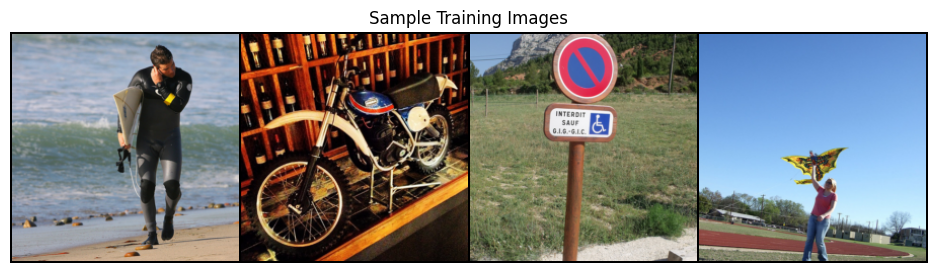

In [ ]:
# 入力画像の可視化
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def denormalize(tensor):
    """ImageNet正規化を元に戻す"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

# サンプル画像を表示
sample_images = denormalize(test_images[:4])
grid = make_grid(sample_images, nrow=4).cpu().permute(1, 2, 0).numpy()
grid = np.clip(grid, 0, 1)

plt.figure(figsize=(12, 3))
plt.imshow(grid)
plt.title("Sample Training Images")
plt.axis("off")
plt.show()

## 次のステップ

1. **ダミーモードで動作確認** → エラーなく完了すればOK
2. **軽量モード（light）で実学習** → T4で数時間
3. **標準モード（standard）で本格学習** → Pro or 研究室PC
4. **推論ノートブック** → `mindeye_inference_colab.ipynb` で画像再構成